<a href="https://www.kaggle.com/mohamedbakrey/using-some-of-model-in-deep-learning-on-cifar10?scriptVersionId=88790754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install ipyplot

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math
import ipyplot

# Lodatain Dataset CIFAR10.


In [3]:
# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step



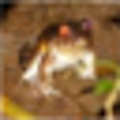
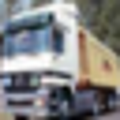
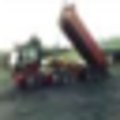
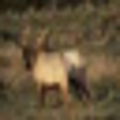
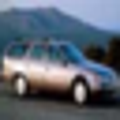
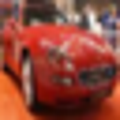
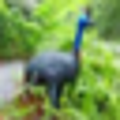
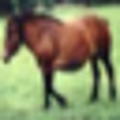
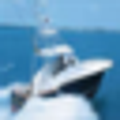
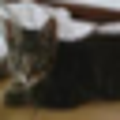


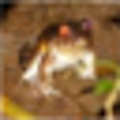
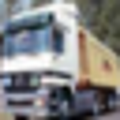
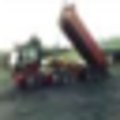
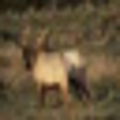
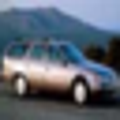
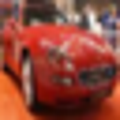
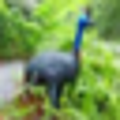
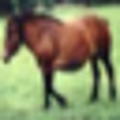
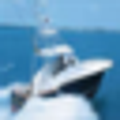
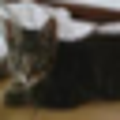

In [4]:
# Show Some of data train image
ipyplot.plot_images(x_train, max_images=10, img_width=120)


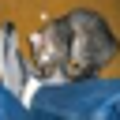
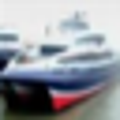
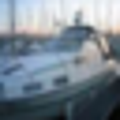
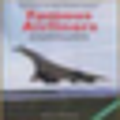
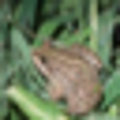
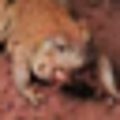
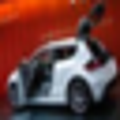
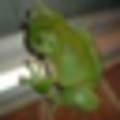
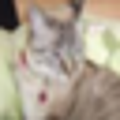
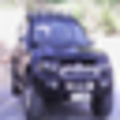


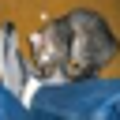
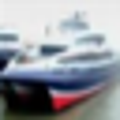
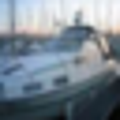
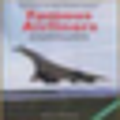
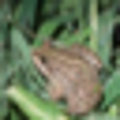
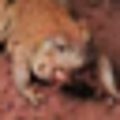
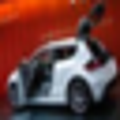
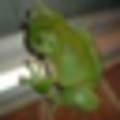
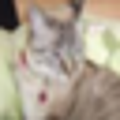
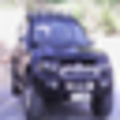

In [5]:
# Show Some of data test image
ipyplot.plot_images(x_test, max_images=10, img_width=120)

In [6]:
# input image dimensions.
input_shape = x_train.shape[1:]
print("Inpit Shape:",input_shape)

Inpit Shape: (32, 32, 3)


# Using ResNet Network

# Normalize data.

In [7]:
# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [8]:
print("Train shape after normalize:", x_train.shape)
print("Test shape after normalize::", x_train.shape)

Train shape after normalize: (50000, 32, 32, 3)
Test shape after normalize:: (50000, 32, 32, 3)


In [9]:
# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10
# subtracting pixel mean improves accuracy
subtract_pixel_mean = True
n = 3
# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1

###  computed depth from supplied model parameter n

In [10]:
# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
print("Model Type:", model_type)


# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean



Model Type: ResNet20v1


In [13]:
# convert class vectors to binary class matrices.
y1_train = to_categorical(y_train, num_classes)
y1_test = to_categorical(y_test, num_classes)

In [14]:
print("shape of y_train after convert to binary class matrices:",y1_train.shape)
print("shape of y_test after convert to binary class matrices:",y1_test.shape)

shape of y_train after convert to binary class matrices: (50000, 10, 10)
shape of y_test after convert to binary class matrices: (10000, 10, 10)


### We can calc the learning Rate

In [15]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [16]:

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [17]:
def resnet_v1(input_shape, depth, num_classes=10):
   
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Using ResNet Version2 (v2)

In [18]:
def resnet_v2(input_shape, depth, num_classes=10):
   
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    # start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU
    # on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                # first layer and first stage
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                # first layer but not first stage
                if res_block == 0:
                    # downsample
                    strides = 2 

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection
                # to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])
model.summary()

# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    steps_per_epoch =  math.ceil(len(x_train) / batch_size)
  




2022-02-26 11:26:16.115945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 11:26:16.229905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 11:26:16.230655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 11:26:16.231806: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
 # fit the model on the batches generated by datagen.flow().
model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)

2022-02-26 11:26:19.081989: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
Learning rate:  0.001


2022-02-26 11:26:22.241201: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1563/1563 [==============================] - 48s 25ms/step - loss: 1.5966 - acc: 0.4807 - val_loss: 1.3472 - val_acc: 0.5650

Epoch 00001: val_acc improved from -inf to 0.56500, saving model to /kaggle/working/saved_models/cifar10_ResNet20v1_model.001.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
Learning rate:  0.001
1563/1563 [==============================] - 38s 25ms/step - loss: 1.1664 - acc: 0.6470 - val_loss: 1.6251 - val_acc: 0.5502

Epoch 00002: val_acc did not improve from 0.56500
Epoch 3/50
Learning rate:  0.001
1563/1563 [==============================] - 38s 24ms/step - loss: 1.0036 - acc: 0.7080 - val_loss: 1.1538 - val_acc: 0.6687

Epoch 00003: val_acc improved from 0.56500 to 0.66870, saving model to /kaggle/working/saved_models/cifar10_ResNet20v1_model.003.h5
Epoch 4/50
Learning rate:  0.001
1563/1563 [==============================] - 38s 25ms/step - loss: 0.9167 - acc: 0.7390 - val_loss: 1.0868 - val_acc: 0.6911

Epoch 00004: val_acc improved from 0.66870 to 0.69110, saving model to /kaggle/working/saved_models/cifar10_ResNet20v1_model.004.h5
Epoch 5/50
Learning rate:  0.001
1563/1563 [==============================] - 38s 24ms/step - loss: 0.8565 - acc: 0.7639 - val_loss: 0.8612 - val_acc: 0.7664

Epoch 00005: val_acc improved from 0.69110 to 0.76

In [20]:
# score trained model
scores = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)

In [21]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]*100)

Test loss: 0.760461688041687
Test accuracy: 83.71999859809875


In [24]:
from keras.models import load_model
model.save("ResNet.h5")
loaded_model = load_model("ResNet.h5")
loaded_model


# Using DensNet Network

In [34]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

In [42]:
from tensorflow.keras.layers import concatenate, Activation
# training parameters
batch_size = 32
epochs = 5
data_augmentation = True

# network parameters
num_classes = 10
num_dense_blocks = 3
use_max_pool = False
growth_rate = 12
depth = 100
num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)

num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.5

In [36]:
# start model definition
# densenet CNNs (composite function) are made of BN-ReLU-Conv2D
inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(num_filters_bef_dense_block,
           kernel_size=3,
           padding='same',
           kernel_initializer='he_normal')(x)
x = concatenate([inputs, x])

# stack of dense blocks bridged by transition layers
for i in range(num_dense_blocks):
    # a dense block is a stack of bottleneck layers
    for j in range(num_bottleneck_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4 * growth_rate,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = concatenate([x, y])

    # no transition layer after the last dense block
    if i == num_dense_blocks - 1:
        continue

    # transition layer compresses num of feature maps and reduces the size by 2
    num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
    num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
    y = BatchNormalization()(x)
    y = Conv2D(num_filters_bef_dense_block,
               kernel_size=1,
               padding='same',
               kernel_initializer='he_normal')(y)
    if not data_augmentation:
        y = Dropout(0.2)(y)
    x = AveragePooling2D()(y)

In [37]:
# add classifier on top
# after average pooling, size of feature map is 1 x 1
x = AveragePooling2D(pool_size=8)(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                kernel_initializer='he_normal',
                activation='softmax')(y)

# instantiate and compile model
# orig paper uses SGD but RMSprop works better for DenseNet
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(1e-3),
              metrics=['acc'])


In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 32, 32, 3)    12          input_5[0][0]                    
__________________________________________________________________________________________________
activation_118 (Activation)     (None, 32, 32, 3)    0           batch_normalization_120[0][0]    
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 32, 32, 24)   672         activation_118[0][0]             
____________________________________________________________________________________________

In [44]:
plot_model(model, to_file='DensNet.png', show_shapes=True)

In [39]:
# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file="cifar10-densenet.png", show_shapes=True)

# prepare model model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_densenet_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate reducer
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    steps_per_epoch = math.ceil(len(x_train) / batch_size)

Using real-time data augmentation.


In [45]:
  # fit the model on the batches generated by datagen.flow().
model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)

Epoch 1/5
Learning rate:  0.001
1563/1563 [==============================] - 159s 102ms/step - loss: 1.0005 - acc: 0.6446 - val_loss: 1.5353 - val_acc: 0.5385

Epoch 00001: val_acc improved from -inf to 0.53850, saving model to /kaggle/working/saved_models/cifar10_densenet_model.01.h5
Epoch 2/5
Learning rate:  0.001
1563/1563 [==============================] - 157s 101ms/step - loss: 0.7658 - acc: 0.7334 - val_loss: 0.9519 - val_acc: 0.6989

Epoch 00002: val_acc improved from 0.53850 to 0.69890, saving model to /kaggle/working/saved_models/cifar10_densenet_model.02.h5
Epoch 3/5
Learning rate:  0.001
1563/1563 [==============================] - 152s 97ms/step - loss: 0.6546 - acc: 0.7743 - val_loss: 0.7900 - val_acc: 0.7385

Epoch 00003: val_acc improved from 0.69890 to 0.73850, saving model to /kaggle/working/saved_models/cifar10_densenet_model.03.h5
Epoch 4/5
Learning rate:  0.001
1563/1563 [==============================] - 153s 98ms/step - loss: 0.5746 - acc: 0.8021 - val_loss: 0.81

In [46]:
# score trained model
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])


Test loss: 0.5358282327651978


In [48]:
print('Test accuracy:', scores[1]*100)

Test accuracy: 81.7799985408783
